<a href="https://www.kaggle.com/code/sanphats/microcalcification-weighting-loss-dnn?scriptVersionId=107215432" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# **Microcalcification classification**
---

## **Overview of breast calcification:**

According to [breastcancer.org](https://www.breastcancer.org/screening-testing/mammograms/what-mammograms-show/calcifications)
- Calcifications are small deposits of calcium seen in mammograms images as bright white dots on breasts.
- Based on the size, shape and cluster of calcifications,

    - It's more likely to be benigh if calcifications:
        - are larger calcifications (>0.5 mm)
        - have well-defined edges and fairly standard shapes
        - are not clustered in one area of breast
    - while it's more likely to be associated with a cancerous process if they:
        - are smaller than 0.5 mm each
        - vary in size and shape
        - are clustered in one area of breast


![](https://www.mdpi.com/sensors/sensors-21-04854/article_deploy/html/images/sensors-21-04854-g002.png)
Thanks Khalil ur Rehman and his colleagues for this image. You can find his paper [here](https://www.mdpi.com/1424-8220/21/14/4854/htm)

---


# **Cleaning data**

In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px


%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
# # Import series of helper functions for our notebook
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

from helper_functions import make_confusion_matrix

--2022-10-04 22:29:57--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-10-04 22:29:58 (42.6 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [3]:
# parse csv 
csv_url = '../input/microcalcification-classification/microcalcification.csv'
df = pd.read_csv(csv_url)
df.sample(5)


,Area,Grey Level,Gradient Strength,Noise Fluctuation,Contrast,Shape Descriptor,Microcalcification
3130,0.295401,0.184498,0.896060,1.401225,-0.377866,1.083649,'-1'
145,-0.784415,-0.470195,-0.591631,-0.859553,-0.377866,-0.945723,'-1'
881,-0.784415,-0.470195,-0.591631,-0.859553,-0.377866,-0.945723,'-1'
11152,-0.784415,-0.470195,-0.591631,-0.859553,-0.377866,-0.945723,'-1'
8688,0.077575,-0.439230,-0.185897,-0.859553,-0.377866,-0.945723,'-1'


In [4]:
# check NULL data
null = round(100 *(df.isna().sum()/df.shape[0]).sort_values(ascending = False) ,2)
null.to_frame(name = 'percent NULL data (%)')

,percent NULL data (%)
Area,0.0
Grey Level,0.0
Gradient Strength,0.0
Noise Fluctuation,0.0
Contrast,0.0
Shape Descriptor,0.0
Microcalcification,0.0


#### No NULL data found ✅

In [5]:
# check duplicated data
print('percent duplicated data is {} %'.format(round(100 * df.duplicated().sum()/df.shape[0],2)))

percent duplicated data is 29.81 %


#### Duplicated data found ! 🛑

In [6]:
# remove duplicated data
df_no_dup = df.drop_duplicates(keep ='first')
print('percent duplicated data is %.2f' %(100 * df_no_dup.duplicated().sum()/df_no_dup.shape[0]))

percent duplicated data is 0.00


In [7]:
# Change ['Microcalcification'] values  {'-1' : 0 , '1': 1}
df_no_dup['Microcalcification'] = df_no_dup['Microcalcification'].str.replace("'","")
df_no_dup['Microcalcification'] = df_no_dup['Microcalcification'].apply(lambda x: 0 if x == '-1' else 1)
df_no_dup.sample(5)

,Area,Grey Level,Gradient Strength,Noise Fluctuation,Contrast,Shape Descriptor,Microcalcification
3492,-0.067417,-0.399418,0.264918,0.860292,-0.377866,1.114120,0
8224,-0.322169,-0.346334,-0.185897,0.926116,2.098481,0.934341,0
6421,-0.357739,-0.403841,0.039510,-0.264611,3.189428,0.650960,0
7904,-0.134662,-0.169390,1.076386,0.849744,0.172909,0.983095,0
7264,-0.212239,-0.425959,0.129673,-0.124104,0.720161,0.916058,0


# **Handling Class imbalance**

In [8]:
# Check class imbalance
fig = px.histogram(df_no_dup, x="Microcalcification",  nbins = 2,
                   color = 'Microcalcification', template = 'simple_white', title ='Class Imbalance',
                   width=400, height=400)
fig.update_xaxes(type='category')
fig.show()

print('Percent of Microcalcification : {} %'.format(round(100*df_no_dup['Microcalcification'].sum()/df_no_dup.shape[0],2)))

Percent of Microcalcification : 3.24 %


## **Sample Weighting in Loss Function**
I will weight the contributions of positive and negative losses to be equal. One way of doing this is by multiplying each example by a weight factor, $w_{pos}$ and $w_{neg}$, so that the overall contribution of is the same. 

Firstly, compute class frequencies

In [9]:
freq_pos = round(df_no_dup['Microcalcification'].sum()/df_no_dup.shape[0],3)
freq_neg = 1 - freq_pos

print('pos freqs: {}'.format(freq_pos))
print('neg freqs: {}'.format(freq_neg))

pos freqs: 0.032
neg freqs: 0.968


As we know that the contributions of positive cases is significantly lower than that of the negative ones.
However, we want the contributions to be equal. So we want

$$w_{pos} \times freq_{p} = w_{neg} \times freq_{n},$$

which we can do simply by taking 

$$w_{pos} = freq_{neg}$$
$$w_{neg} = freq_{pos}$$

This way, we will be balancing the contribution of positive and negative labels.

In [10]:
pos_weights = freq_neg
neg_weights = freq_pos
pos_contribution = freq_pos * pos_weights 
neg_contribution = freq_neg * neg_weights

Let's verify this by graphing the two contributions next to each other:

In [11]:
data = pd.DataFrame({'Class': [1, 0], 
                     'Label': ['Positive', 'Negative'],
                     'Value': [pos_contribution, neg_contribution]})

fig = px.histogram(data, x="Label", y = 'Value', nbins = 2,
                   color = 'Class', template = 'simple_white',
                   width=400, height=400,
                   labels=dict(Value ="Weight"))
fig.update_xaxes(type='category')
fig.show()

Now the positive and negative labels have an equal contribution to the loss function. 
Let's work on a loss function. 

After computing the weights, the final weighted loss for each example will be 
$$\mathcal{L}_{cross-entropy}^{w}(x) = - (w_{p} y \log(f(x)) + w_{n}(1-y) \log( 1 - f(x) ) ).$$

## **Weight loss**

**Note :** a small value,  ϵ , to the predicted values before taking their logs. This is simply to avoid a numerical error that would otherwise occur if the predicted value happens to be zero.

In [12]:
from keras import backend as K
def get_weighted_loss(pos_weights, neg_weights, epsilon=1e-7):
    
    def weighted_loss(y_true, y_pred):
        # initialize loss to zero
        loss = 0.0
        
        # for each class, add average weighted loss for that class 
        loss += K.mean(-(pos_weights *y_true * K.log(y_pred + epsilon) 
                             + neg_weights* (1 - y_true) * K.log( 1 - y_pred + epsilon))) 
        return loss
    
    return weighted_loss

In [13]:
# Test the get_weighted_loss function
y_true = np.array([1,0,1,1])
    
w_p = np.array([0.25])
w_n = np.array([0.75])

y_pred1 = np.array((0.7*np.ones(y_true.shape)))
y_pred2 = np.array((0.3*np.ones(y_true.shape)))

L = get_weighted_loss(w_p, w_n, epsilon=1)
L1 = L(y_true, y_pred1)
L2 = L(y_true, y_pred2)

print('\nThe two losses are expected to be the same.')
print('L(y_pred_1)= {}, L(y_pred_2)= {}'.format(L1,L2))
print('Difference is L1 - L2 = {}'.format(L1 - L2))


The two losses are expected to be the same.
L(y_pred_1)= -0.14868609666181154, L(y_pred_2)= -0.14868609666181154
Difference is L1 - L2 = 0.0


2022-10-04 22:30:08.197590: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


# **Preprocess data**

In [14]:
from  sklearn.model_selection import train_test_split 
from sklearn.preprocessing import StandardScaler

# Preprocessing data

def preprocessing_data(df = df_no_dup, training_size = 0.8):
  
  # Given x, y 
  x = df.drop(columns = ['Microcalcification'])
  y = df['Microcalcification']


  # Train-test split (train data 80%)
  x_train, x_test, y_train, y_test = train_test_split(x, y, train_size= training_size, shuffle=True, random_state=42)

  # Standard scaling x
  scaler = StandardScaler()
  scaler.fit(x_train)
  x_train = pd.DataFrame(scaler.transform(x_train), index=x_train.index, columns=x_train.columns)
  x_test = pd.DataFrame(scaler.transform(x_test), index=x_test.index, columns=x_test.columns)


  return x_train, x_test, y_train, y_test

x_train, x_test, y_train, y_test = preprocessing_data()

In [15]:
# convert to np.array and change y type to float
x_train = np.array(x_train)
y_train = np.array(y_train).astype(np.float)
x_test = np.array(x_test)
y_test = np.array(y_test).astype(np.float)

# **Create DNN Model**

Set our custom loss function for the model by specifying the `loss` parameter in the `compile()` function.

In [16]:
# create model
import tensorflow as tf
import os

def create_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(512, kernel_initializer= 'he_uniform', input_shape = (6,)),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(256 ,  kernel_initializer= 'he_uniform'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(128,  kernel_initializer= 'he_uniform'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(64 ,  kernel_initializer= 'he_uniform'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(64 ,  kernel_initializer= 'he_uniform'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(1 , activation = 'sigmoid')])
    
    model.compile( loss = get_weighted_loss(pos_weights, neg_weights), optimizer = 'adam', metrics = ['accuracy'])
    
    return model

model = create_model()


In [17]:
# create callbacks
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

checkpoint_path = "./training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

MC = ModelCheckpoint(filepath= checkpoint_path, verbose =2, save_weights_only=True )
RLR = ReduceLROnPlateau(monitor = 'loss', factor = 0.2, patience = 5, verbose =2, min_lr =0.001)

## MyCallBack class
# Stop training when reach 96% accuracy
import tensorflow as tf
class mycallback(tf.keras.callbacks.Callback):
  def __init__(self, threshold):
    self.threshold = threshold
  def on_epoch_end(self, epoch, logs = {}):
    if (logs.get('accuracy') >= self.threshold) :
      print('\nStop Training!\n')
      self.model.stop_training = True
callbacks = mycallback(0.96)

In [18]:
# fit the model
history = model.fit(x_train, y_train, epochs = 100, batch_size = 32, callbacks = [callbacks, MC, RLR], verbose =2)

2022-10-04 22:30:09.542667: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100
197/197 - 2s - loss: 0.1781 - accuracy: 0.6996

Epoch 00001: saving model to ./training_1/cp.ckpt
Epoch 2/100
197/197 - 1s - loss: 0.2822 - accuracy: 0.6347

Epoch 00002: saving model to ./training_1/cp.ckpt
Epoch 3/100
197/197 - 1s - loss: 0.2325 - accuracy: 0.6054

Epoch 00003: saving model to ./training_1/cp.ckpt
Epoch 4/100
197/197 - 1s - loss: 0.1943 - accuracy: 0.7103

Epoch 00004: saving model to ./training_1/cp.ckpt
Epoch 5/100
197/197 - 1s - loss: 0.1952 - accuracy: 0.7815

Epoch 00005: saving model to ./training_1/cp.ckpt
Epoch 6/100
197/197 - 1s - loss: 0.4215 - accuracy: 0.6347

Epoch 00006: saving model to ./training_1/cp.ckpt
Epoch 7/100
197/197 - 1s - loss: 0.4914 - accuracy: 0.6541

Epoch 00007: saving model to ./training_1/cp.ckpt
Epoch 8/100
197/197 - 1s - loss: 0.1838 - accuracy: 0.7984

Epoch 00008: saving model to ./training_1/cp.ckpt
Epoch 9/100
197/197 - 1s - loss: 0.1564 - accuracy: 0.8422

Epoch 00009: saving model to ./training_1/cp.ckpt
Epoch 10/1

In [19]:
# Load trained weights
model = create_model()
model.load_weights(checkpoint_path)

# **Model Evaluation**

## **Plotting Loss and accuracy**

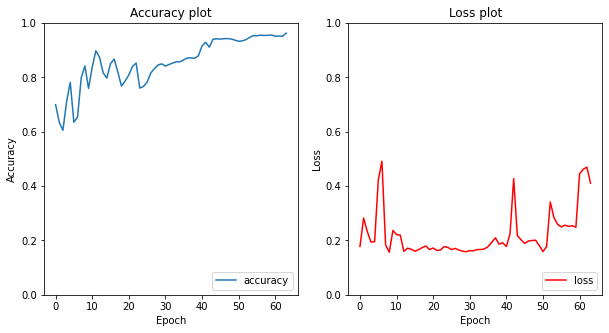

In [20]:
fig, axes = plt.subplots(1,2, figsize = (10,5))
axes[0].plot(history.history['accuracy'], label='accuracy')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].set_ylim([0, 1])
axes[0].legend(loc='lower right')
axes[0].set_title('Accuracy plot')
axes[1].plot(history.history['loss'], label='loss', color = 'red')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].set_ylim([0, 1])
axes[1].legend(loc='lower right')
axes[1].set_title('Loss plot')

fig.show()

## **Evaluate with test dataset**

### **Train-Test Accuracy and Loss**

In [21]:
# Evaluating the model on train and test
score = model.evaluate(x_train, y_train, batch_size= 32)

print("Train Loss: ", score[0])
print("Train Accuracy: ", score[1])

score = model.evaluate(x_test, y_test, batch_size= 32)
print("\nTest loss: ", score[0])
print("Test Accuracy: ", score[1])

197/197 [==============================] - 1s 2ms/step - loss: 0.3868 - accuracy: 0.9721
Train Loss:  0.38677507638931274
Train Accuracy:  0.9721293449401855
50/50 [==============================] - 0s 3ms/step - loss: 0.3988 - accuracy: 0.9720

Test loss:  0.3988109529018402
Test Accuracy:  0.9719745516777039


In [22]:
# predict x_test
y_pred_proba = model.predict(x_test,batch_size = 32)
y_pred = np.where(y_pred_proba > 0.4, 1, 0)

### **Classification report**

In [23]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve, roc_auc_score
print(classification_report(y_test, y_pred))
print("Accuracy of the Model:",accuracy_score(y_test, y_pred)*100,"%")

              precision    recall  f1-score   support

         0.0       0.97      1.00      0.99      1521
         1.0       0.69      0.18      0.29        49

    accuracy                           0.97      1570
   macro avg       0.83      0.59      0.64      1570
weighted avg       0.97      0.97      0.96      1570

Accuracy of the Model: 97.19745222929936 %


### **Confusion matrix**

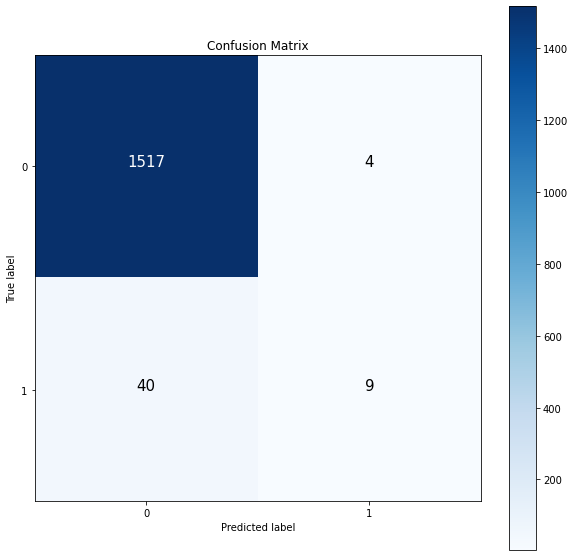

In [24]:
# Confusion Matrix
make_confusion_matrix(y_test, y_pred)


### **ROC curve**

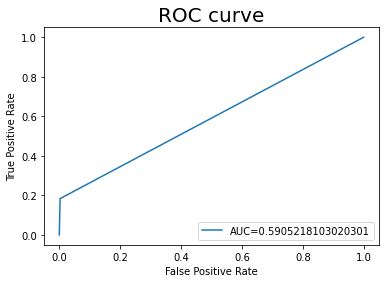

In [25]:
fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)

#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC curve', fontsize = 20)
plt.legend(loc=4)
plt.show()

---
#### Thank you for reading. 😃
#### Please feel free to leave comments. Apprecite you all 🙏

---
SANPHAT S.